<a href="https://colab.research.google.com/github/manikanta70137/Credit-Card-Fraud-Detection/blob/main/Resuls_and_Comparision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

Class
0    284315
1       492
Name: count, dtype: int64
Normal share = 99.83
Fraud share = 0.17


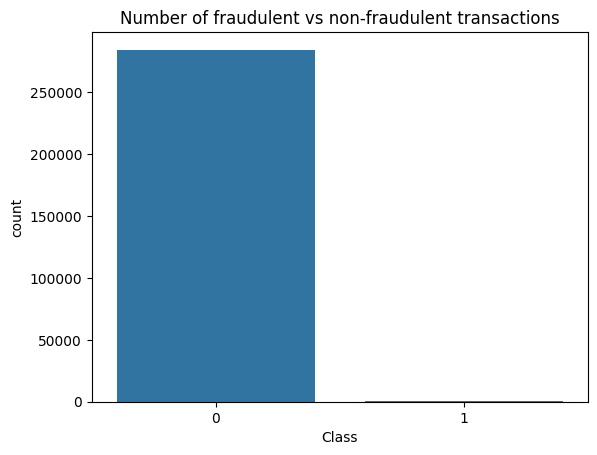

In [23]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/creditcard.csv')

# Check class distribution
classes = df['Class'].value_counts()
print(classes)

# Calculate percentage shares of normal and fraud transactions
normal_share = round((classes[0] / df['Class'].count() * 100), 2)
fraud_share = round((classes[1] / df['Class'].count() * 100), 2)
print("Normal share =", normal_share)
print("Fraud share =", fraud_share)

# Plot class distribution
sns.countplot(x='Class', data=df)
plt.title('Number of fraudulent vs non-fraudulent transactions')
plt.show()

In [24]:
# Define features (X) and target (y)
X = df.drop(['Class'], axis=1)
y = df['Class']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

scaler = StandardScaler()
# Fit on training data and transform
X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
# Transform test data
X_test['Amount'] = scaler.transform(X_test[['Amount']])

# Apply power transformation to reduce skewness
pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=False)
X_train = pt.fit_transform(X_train)
X_test = pt.transform(X_test)

ros = RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Check class distribution after oversampling
print('Before sampling:', Counter(y_train))
print('After sampling:', Counter(y_train_ros))

Before sampling: Counter({0: 227449, 1: 396})
After sampling: Counter({0: 227449, 1: 227449})


In [25]:
import xgboost as xgb

# Define and train XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
xgb_model.fit(X_train_ros, y_train_ros)

# Predict on test set and evaluate
y_pred_test_xgb = xgb_model.predict(X_test)

In [31]:
# Define input shape for LSTM model
input_shape = (X_train_ros.shape[1], 1)
inputs = tf.keras.layers.Input(shape=input_shape)
l1 = tf.keras.layers.LSTM(64, activation='tanh')(inputs)
l1 = tf.keras.layers.Dropout(0.20)(l1)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(l1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train LSTM model
history = model.fit(
    X_train_ros.reshape(X_train_ros.shape[0], X_train_ros.shape[1], 1),
    y_train_ros,
    validation_split=0.20,
    epochs=2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]
)

Epoch 1/2
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 219s 19ms/step - accuracy: 0.9524 - loss: 0.1452 - val_accuracy: 0.9719 - val_loss: 0.0649
Epoch 2/2
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 213s 19ms/step - accuracy: 0.9938 - loss: 0.0213 - val_accuracy: 0.9973 - val_loss: 0.0085


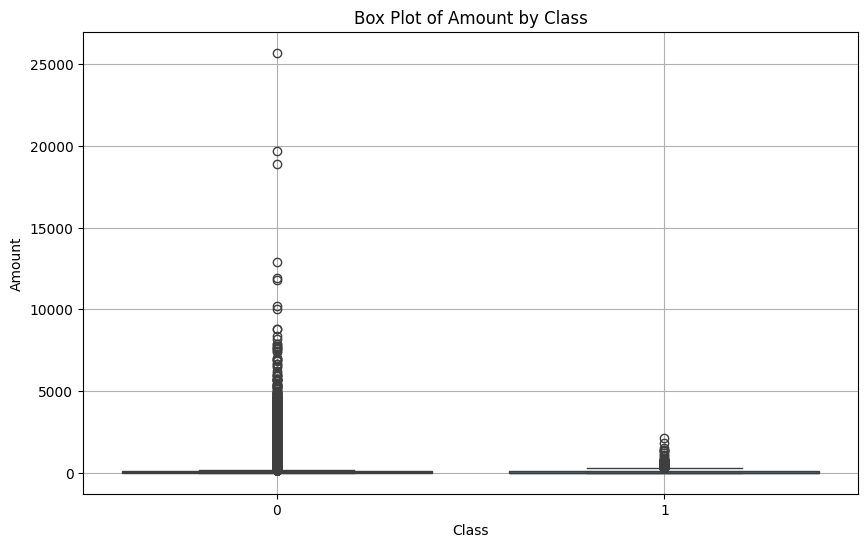

In [44]:
# Assuming 'Amount' is one of the features to visualize
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Box Plot of Amount by Class')
plt.xlabel('Class')
plt.ylabel('Amount')
plt.grid()
plt.show()

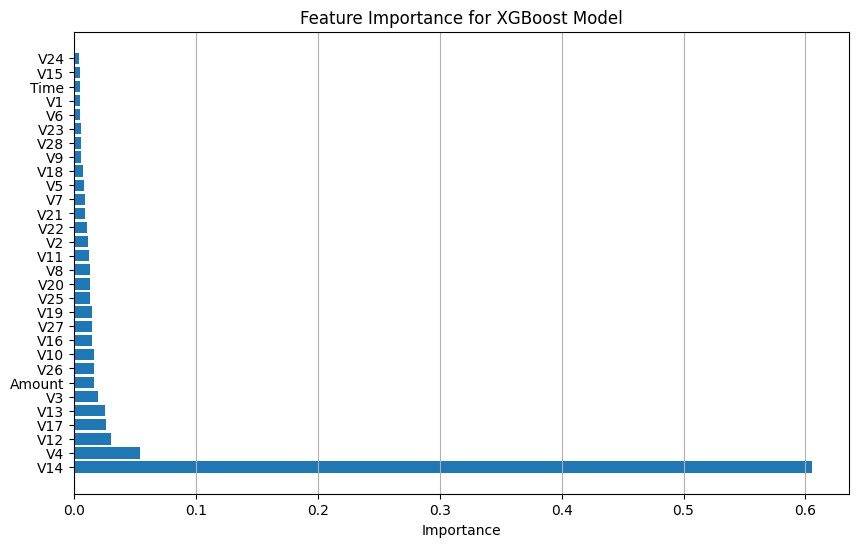

In [41]:
importance = xgb_model.feature_importances_

# Create a DataFrame for better visualization
import pandas as pd

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for XGBoost Model')
plt.grid(axis='x')
plt.show()

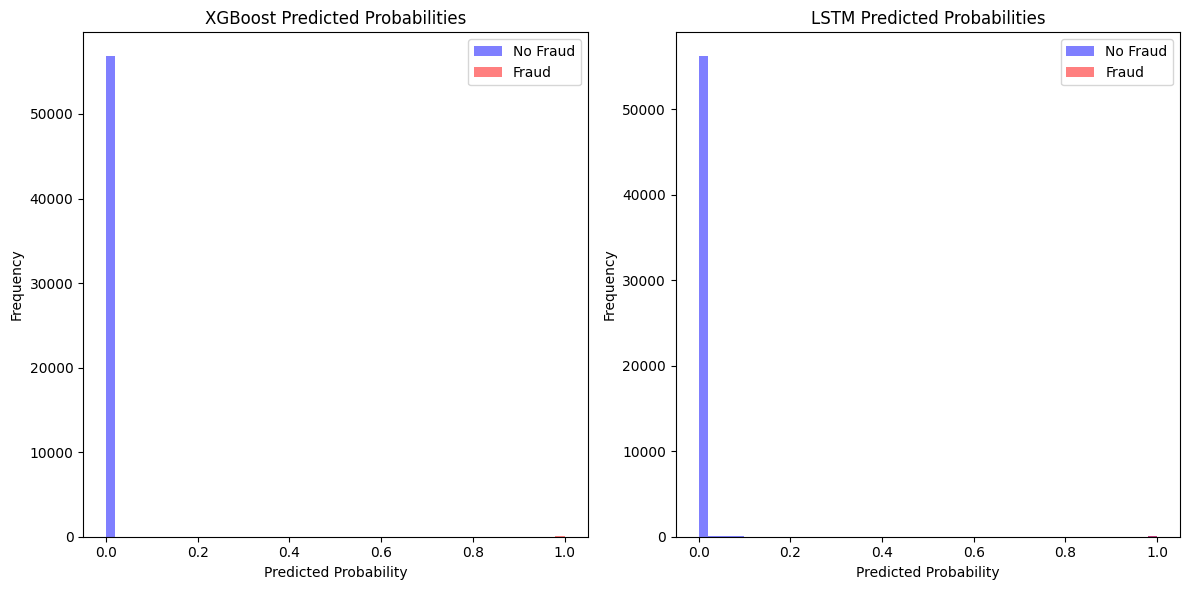

In [43]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(xgb_y_pred_prob[y_test == 0], bins=50, alpha=0.5, label='No Fraud', color='blue')
plt.hist(xgb_y_pred_prob[y_test == 1], bins=50, alpha=0.5, label='Fraud', color='red')
plt.title('XGBoost Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(lstm_y_pred_prob[y_test == 0], bins=50, alpha=0.5, label='No Fraud', color='blue')
plt.hist(lstm_y_pred_prob[y_test == 1], bins=50, alpha=0.5, label='Fraud', color='red')
plt.title('LSTM Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


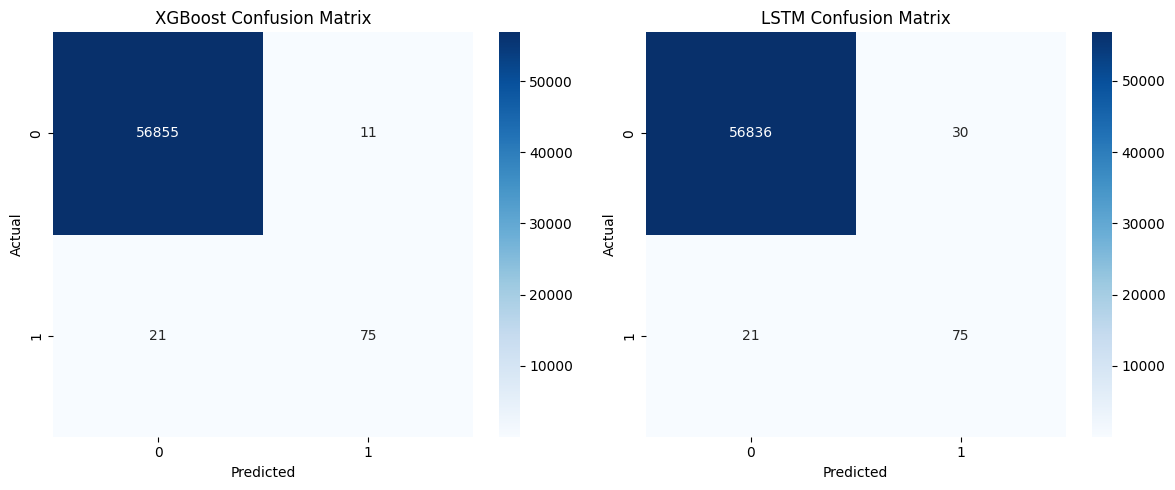

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Confusion Matrices
conf_matrix_xgb = [[56855, 11], [21, 75]]  # Replace with actual matrix if computed differently
conf_matrix_lstm = [[56836, 30], [21, 75]]  # Replace with actual matrix if computed differently

# Plot Confusion Matrices side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# XGBoost Confusion Matrix
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("XGBoost Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# LSTM Confusion Matrix
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("LSTM Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


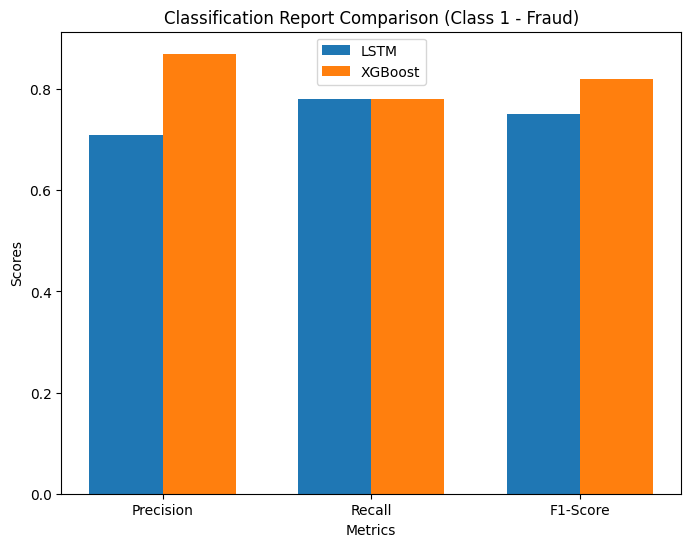

In [11]:
import numpy as np

# Classification report data
metrics = ['Precision', 'Recall', 'F1-Score']
xgb_scores = [0.87, 0.78, 0.82]  # From XGBoost classification report (Class 1)
lstm_scores = [0.71, 0.78, 0.75]  # From LSTM classification report (Class 1)

# Plot comparison
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width/2, lstm_scores, width, label='LSTM')
ax.bar(x + width/2, xgb_scores, width, label='XGBoost')

ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_title("Classification Report Comparison (Class 1 - Fraud)")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step


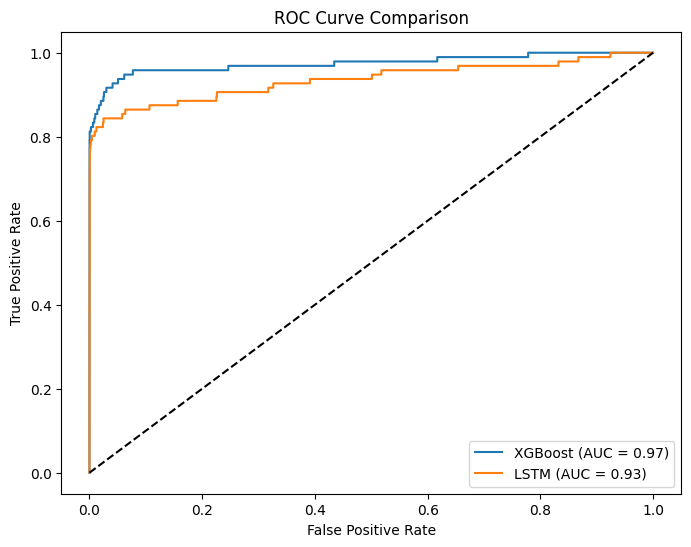

In [46]:
xgb_y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
lstm_y_pred_prob = model.predict(X_test_reshaped)


# ROC Curve for XGBoost and LSTM
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_y_pred_prob)  # Replace with actual XGBoost probability predictions
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_y_pred_prob)  # Replace with actual LSTM probability predictions
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {roc_auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()


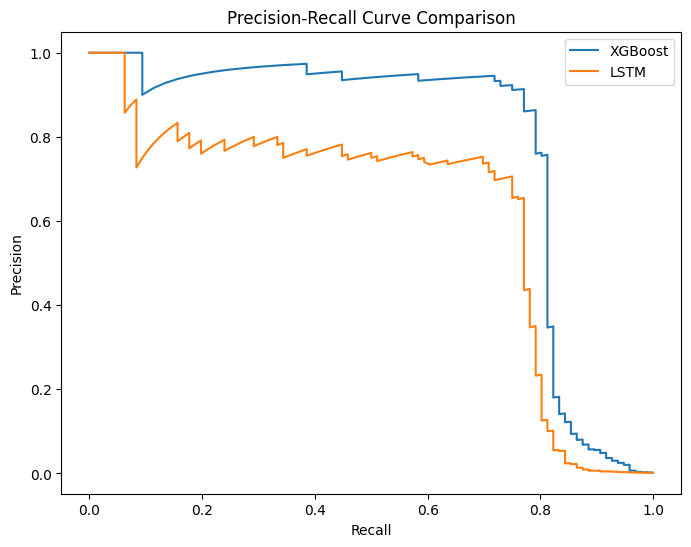

In [36]:
# Precision-Recall Curve for XGBoost and LSTM
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgb_y_pred_prob)
precision_lstm, recall_lstm, _ = precision_recall_curve(y_test, lstm_y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall_xgb, precision_xgb, label="XGBoost")
plt.plot(recall_lstm, precision_lstm, label="LSTM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend(loc="upper right")
plt.show()


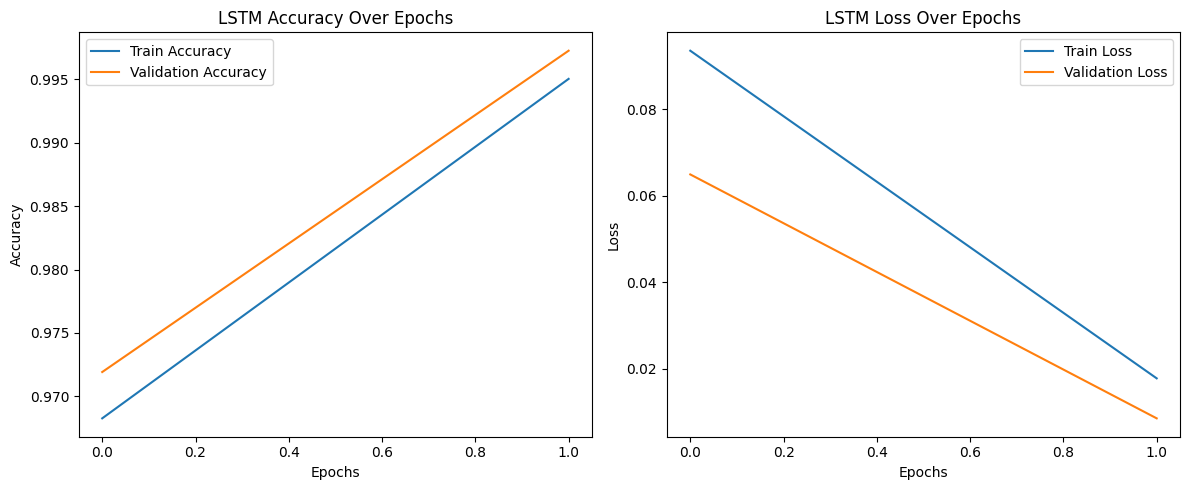

In [37]:
# Assuming `history` is the history object from LSTM training
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("LSTM Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
